(1) Run the code below and arrange the results. 

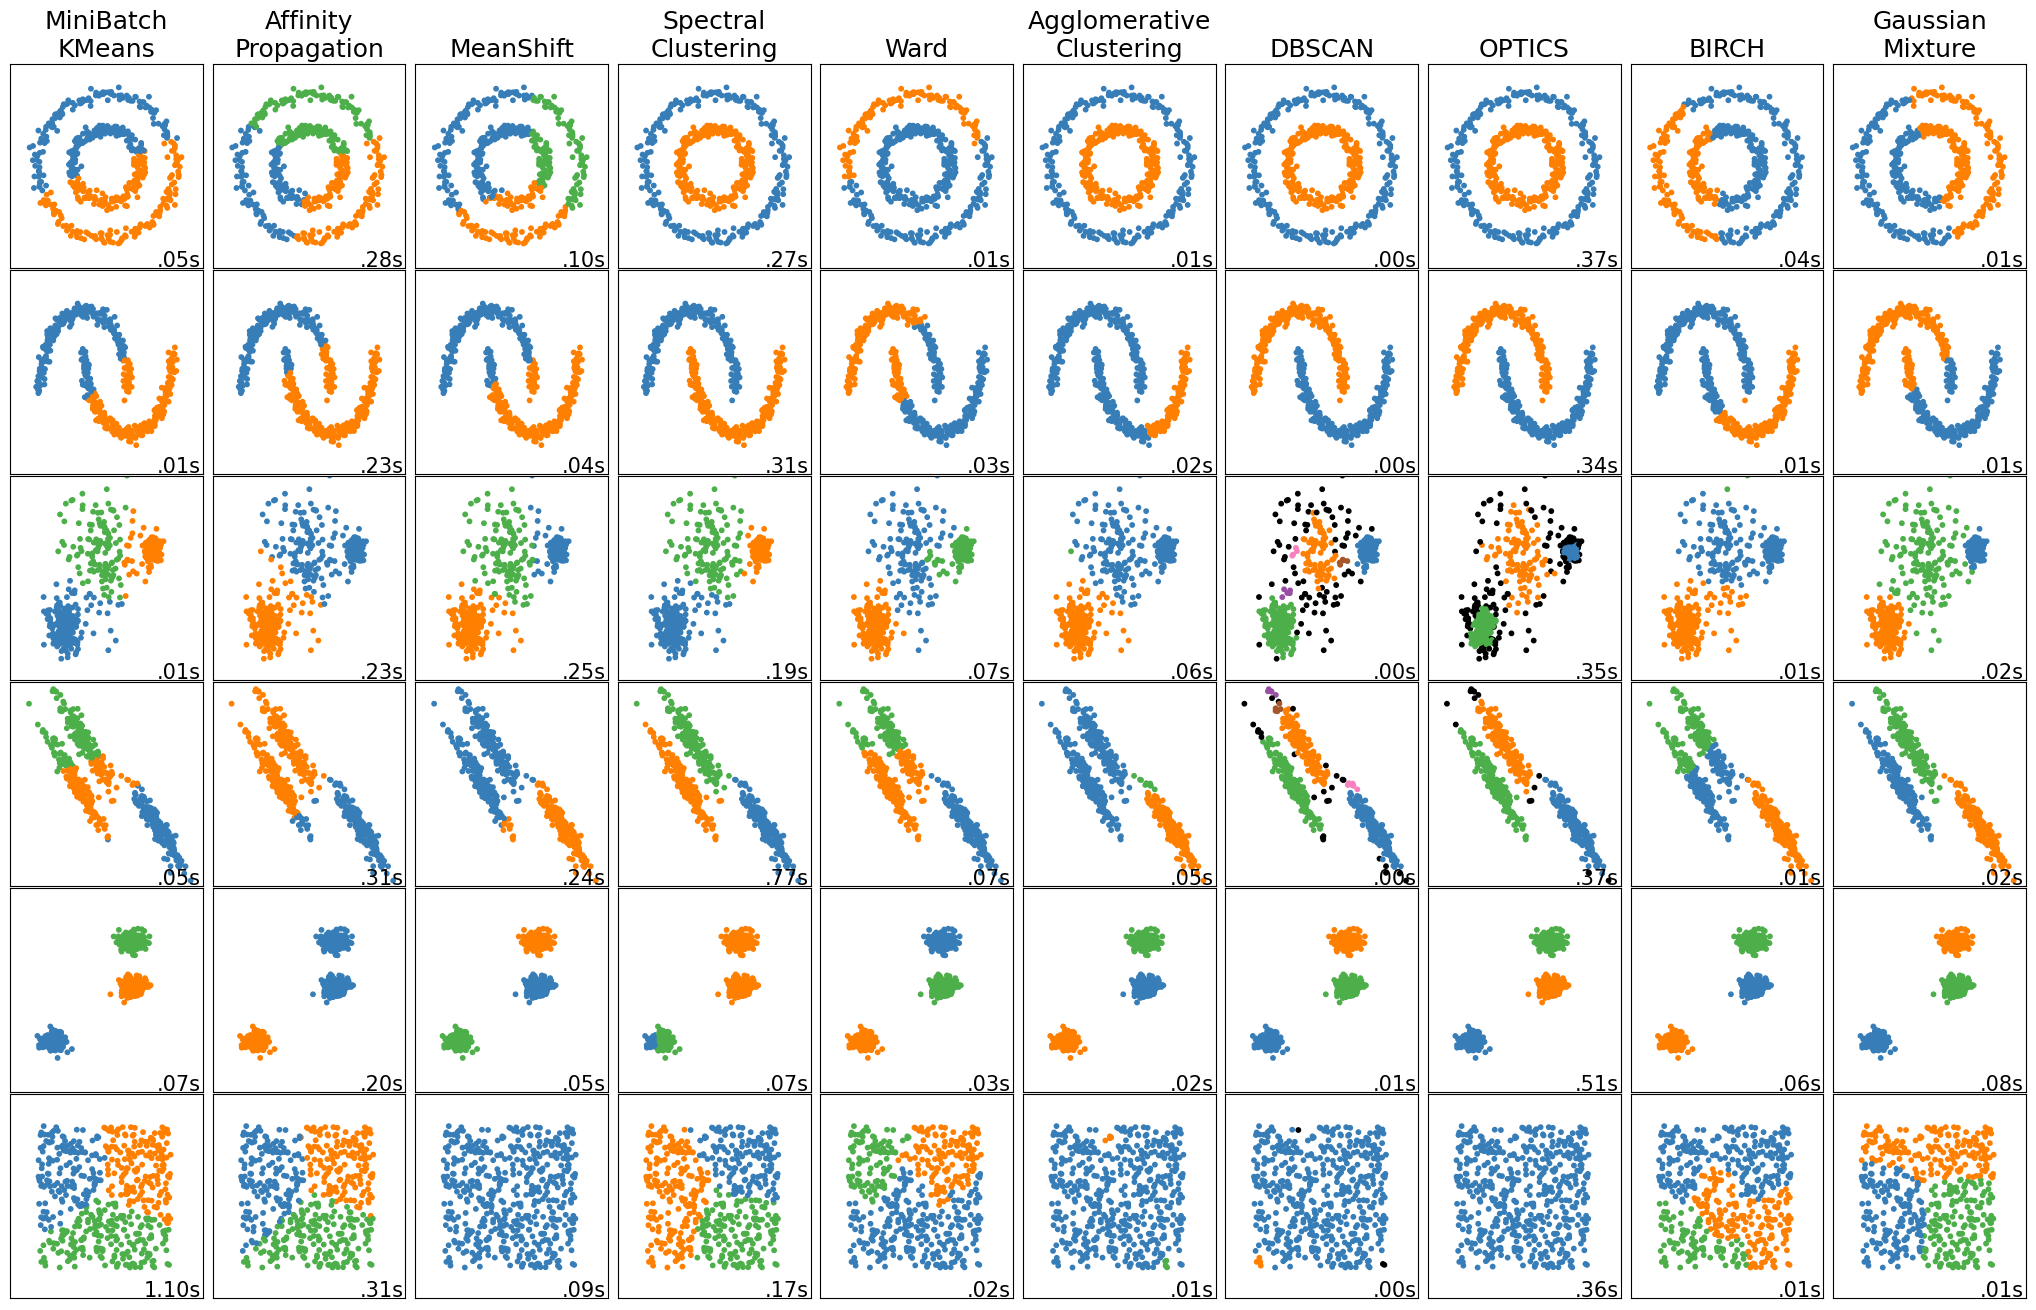

In [5]:
# 01
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

(2) Sample 100 images randomly for each class (total 1000 images) from the MNIST training data set. 

In [6]:
# 02
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
import random
import numpy as np

random.seed(0)

X = np.array(mnist['data'])
y = np.array(mnist['target'])
sample_X = []
sample_y = []

indices = {str(i): [] for i in range(10)}

for num, label in enumerate(y):
    indices[label].append(num)

choices = []
sample_size = 100

for label in indices:
    choices.extend(random.sample(indices[label], sample_size))

for index in choices:
    sample_X.append(X[index])
    sample_y.append(y[index])

sample_X = np.array(sample_X)
sample_y = np.array(sample_y)

print(sample_X.shape)
print(sample_y.shape)


(1000, 784)
(1000,)


(3) For 1000 images, perform Agglomerative clustering, k-means clustering, Gaussian mixture model, 
Spectral clustering. (i.e., k = 10) 


In [61]:
# 03
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.neighbors import kneighbors_graph

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(sample_X, n_neighbors=params["n_neighbors"], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

#Agglomerative clustering
Agg_Clur = AgglomerativeClustering(n_clusters= 10, linkage="ward", connectivity=connectivity).fit(sample_X)

#K-means clustering
kmeans = KMeans(n_clusters=10).fit(sample_X)

#Gaussian Mixture
gaussian = GaussianMixture(n_components=10, covariance_type="full").fit(sample_X)

#Spectral clustering
spectral = SpectralClustering(n_clusters=10, eigen_solver = 'arpack', affinity='nearest_neighbors').fit(sample_X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(4) Based on the clustering results and the labels we know, compute “Rand index” and “mutual 
information based score”. Explain your findings. 

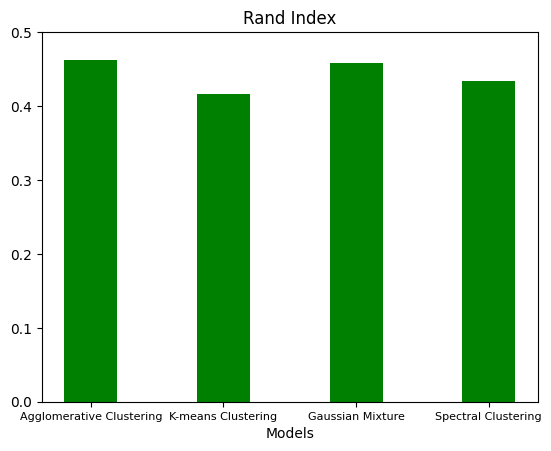

[0.46215893886949044, 0.4157956777307, 0.4582259755751504, 0.43436181159186726]


In [62]:
# 04
import matplotlib.pyplot as plt

rand_score_list = []

Agg_clur_rand_score = adjusted_rand_score(sample_y, Agg_Clur.labels_)
kmeans_rand_score = adjusted_rand_score(sample_y, kmeans.labels_)
guassian_rand_score = adjusted_rand_score(sample_y, gaussian.predict(sample_X))
spectral_rand_score = adjusted_rand_score(sample_y, spectral.labels_)

rand_score_list.extend([Agg_clur_rand_score, kmeans_rand_score, guassian_rand_score, spectral_rand_score])

plt.title("Rand Index")
plt.bar(['Agglomerative Clustering', 'K-means Clustering', 'Gaussian Mixture', 'Spectral Clustering'], rand_score_list, width=0.4, color="green")
plt.xticks(fontsize=8)
plt.xlabel('Models')
plt.ylim([0, 0.5])
plt.show()

print(rand_score_list)


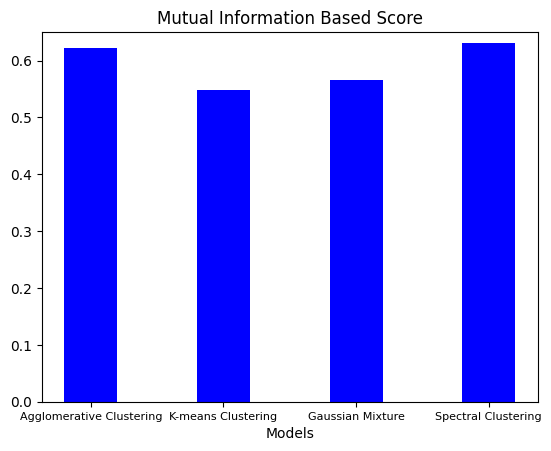

[0.6221374614694467, 0.549079575260931, 0.5660788128612881, 0.6300246650970622]


In [63]:
import matplotlib.pyplot as plt

mutual_score_list = []

Agg_clur_mutual_score = adjusted_mutual_info_score(sample_y, Agg_Clur.labels_)
kmeans_mutual_score = adjusted_mutual_info_score(sample_y, kmeans.labels_)
guassian_mutual_score = adjusted_mutual_info_score(sample_y, gaussian.predict(sample_X))
spectral_mutual_score = adjusted_mutual_info_score(sample_y, spectral.labels_)

mutual_score_list.extend([Agg_clur_mutual_score, kmeans_mutual_score, guassian_mutual_score, spectral_mutual_score])

plt.title("Mutual Information Based Score")
plt.bar(['Agglomerative Clustering', 'K-means Clustering', 'Gaussian Mixture', 'Spectral Clustering'], mutual_score_list, width=0.4, color="blue")
plt.xticks(fontsize=8)
plt.xlabel('Models')
plt.ylim([0, 0.65])
plt.show()

print(mutual_score_list)


(5) Based on the clustering results, you can get the center of each cluster. Classify the MNIST test data set 
using 1-NN classifier and provide accuracy. Explain your findings. 


In [93]:
# 05
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

# Calculate Agglomerative Clustering
clf = NearestCentroid()
clf.fit(sample_X, Agg_Clur.labels_)
X = clf.centroids_

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(sample_X)

Y = []
for cluster_center in X:
  distances, indices = neigh.kneighbors([cluster_center])
  nearest_label = sample_y[indices[0][0]]
  Y.append(str(nearest_label))
Y = np.array(Y)

KNN_neighbor = KNeighborsClassifier(n_neighbors = 1)
KNN_neighbor.fit(X, Y)
pred_Y = KNN_neighbor.predict(sample_X)
accuracy = accuracy_score(sample_y, pred_Y)
print(f"Agglomerative Clustering + 1NN Accuracy : {accuracy}")




# Calculate K-means Clustering
clf = NearestCentroid()
clf.fit(sample_X, kmeans.labels_)
X = clf.centroids_

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(sample_X)

Y = []
for cluster_center in X:
  distances, indices = neigh.kneighbors([cluster_center])
  nearest_label = sample_y[indices[0][0]]
  Y.append(str(nearest_label))
Y = np.array(Y)

KNN_neighbor = KNeighborsClassifier(n_neighbors = 1)
KNN_neighbor.fit(X, Y)
pred_Y = KNN_neighbor.predict(sample_X)
accuracy = accuracy_score(sample_y, pred_Y)
print(f"K-Means Clustering + 1NN Accuracy : {accuracy}")


# Calculate Gaussian Mixture
X = gaussian.means_

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(sample_X)

Y = []
for cluster_center in X:
  distances, indices = neigh.kneighbors([cluster_center])
  nearest_label = sample_y[indices[0][0]]
  Y.append(str(nearest_label))
Y = np.array(Y)

KNN_neighbor = KNeighborsClassifier(n_neighbors = 1)
KNN_neighbor.fit(X, Y)
pred_Y = KNN_neighbor.predict(sample_X)
accuracy = accuracy_score(sample_y, pred_Y)
print(f"Gaussian Mixture + 1NN Accuracy : {accuracy}")


# Calculate Spectral Clustering
clf = NearestCentroid()
clf.fit(sample_X, spectral.labels_)
X = clf.centroids_

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(sample_X)

Y = []
for cluster_center in X:
  distances, indices = neigh.kneighbors([cluster_center])
  nearest_label = sample_y[indices[0][0]]
  Y.append(str(nearest_label))
Y = np.array(Y)

KNN_neighbor = KNeighborsClassifier(n_neighbors = 1)
KNN_neighbor.fit(X, Y)
pred_Y = KNN_neighbor.predict(sample_X)
accuracy = accuracy_score(sample_y, pred_Y)
print(f"Spectral + 1NN Accuracy : {accuracy}")



Agglomerative Clustering + 1NN Accuracy : 0.603
K-Means Clustering + 1NN Accuracy : 0.591
Gaussian Mixture + 1NN Accuracy : 0.611
Spectral + 1NN Accuracy : 0.583


(6) Run the PCA and Kernel PCA functions on the 1000 images used in (3). Plot the mean image and the 
first 10 eigenvectors (as images). Plot the eigenvalues (in decreasing order) as a function of dimension. 
Describe what you find in both plots.

(1000, 784)
(1000,)


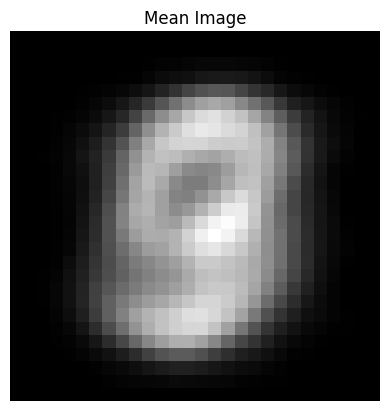

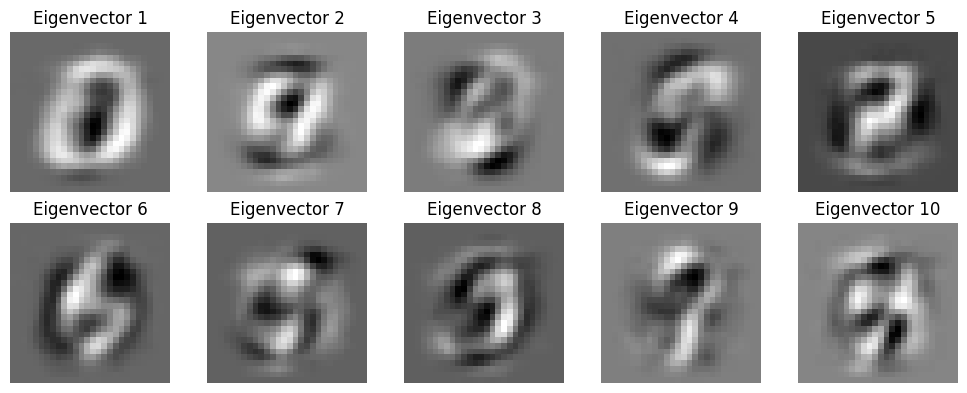

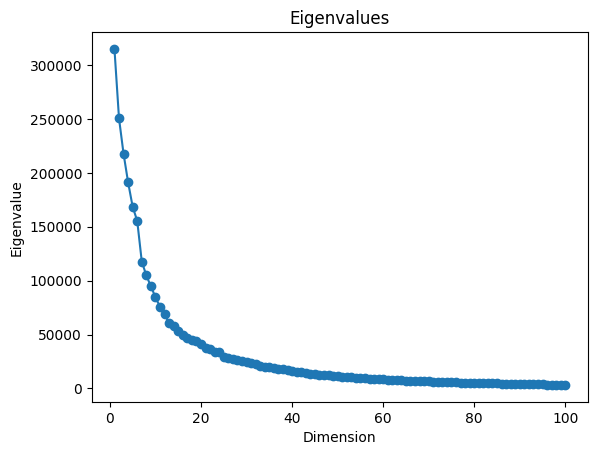

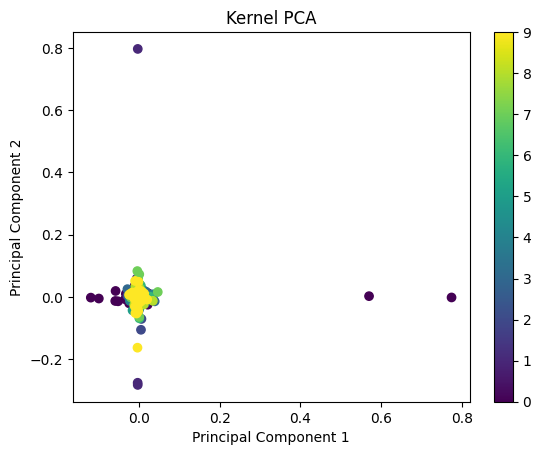

In [94]:
# 06
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

random.seed(0)

X = np.array(mnist['data'])
y = np.array(mnist['target'])
sample_X = []
sample_y = []

indices = {str(i): [] for i in range(10)}

for num, label in enumerate(y):
    indices[label].append(num)

choices = []
sample_size = 100

for label in indices:
    choices.extend(random.sample(indices[label], sample_size))

for index in choices:
    sample_X.append(X[index])
    sample_y.append(y[index])

sample_X = np.array(sample_X)
sample_y = np.array(sample_y)

print(sample_X.shape)
print(sample_y.shape)

# Perform PCA
pca = PCA(n_components = 100) ##
pca_result = pca.fit_transform(sample_X)

# Plot mean image
mean_image = pca.mean_.reshape(28, 28)
plt.imshow(mean_image, cmap='gray')
plt.title('Mean Image')
plt.axis('off')
plt.show()

# Plot first 10 eigenvectors
eigenvectors = pca.components_[:10]
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    eigenvector = eigenvectors[i].reshape(28, 28)
    ax.imshow(eigenvector, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenvector {i+1}')
plt.tight_layout()
plt.show()

# Plot eigenvalues
eigenvalues = pca.explained_variance_
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Eigenvalues')
plt.xlabel('Dimension')
plt.ylabel('Eigenvalue')
plt.show()

# Perform Kernel PCA
kernel_pca = KernelPCA(kernel='rbf')
kernel_pca_result = kernel_pca.fit_transform(sample_X)

# Plot Kernel PCA results
plt.scatter(kernel_pca_result[:, 0], kernel_pca_result[:, 1], c=sample_y.astype(int), cmap='viridis')
plt.title('Kernel PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


(7) Run K-means clustering on the reduced features using the PCA and kernel PCA, respectively. 
Compute “Rand index” and “mutual information based score” on the training data. Explain your findings.

In [32]:
# 07
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Perform K-means clustering on PCA features
kmeans_pca = KMeans(n_clusters=10)
kmeans_pca.fit(pca_result) ##
pca_predictions = kmeans_pca.predict(pca_result)

# Compute Rand index and mutual information-based score on PCA clusters
rand_index_pca = adjusted_rand_score(sample_y, pca_predictions)
mutual_info_pca = adjusted_mutual_info_score(sample_y, pca_predictions)

# Perform K-means clustering on kernel PCA features
kmeans_kernel_pca = KMeans(n_clusters=10)
kmeans_kernel_pca.fit(kernel_pca_result)
kernel_pca_predictions = kmeans_kernel_pca.predict(kernel_pca_result)

# Compute Rand index and mutual information-based score on kernel PCA clusters
rand_index_kernel_pca = adjusted_rand_score(sample_y, kernel_pca_predictions)
mutual_info_kernel_pca = adjusted_mutual_info_score(sample_y, kernel_pca_predictions)

print("Results for K-means clustering on PCA:")
print("Rand index:", rand_index_pca)
print("Mutual information-based score:", mutual_info_pca)
print("\nResults for K-means clustering on Kernel PCA:")
print("Rand index:", rand_index_kernel_pca)
print("Mutual information-based score:", mutual_info_kernel_pca)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Results for K-means clustering on PCA:
Rand index: 0.38905403172884095
Mutual information-based score: 0.5372971152747109

Results for K-means clustering on Kernel PCA:
Rand index: 0.0005251354853777017
Mutual information-based score: 0.014554992801667319


(8) Classify the MNIST test data set using 1-NN classifier and provide accuracy and visualize 3 correctly 
classified and 3 incorrectly classified images for each class. Explain your findings.

In [ ]:
# 08
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train a 1-NN classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(sample_X, sample_y)

# Classify the MNIST test dataset
test_X = X[10000:]  # MNIST test data
test_y = y[10000:]  # MNIST test labels
predicted_labels = knn.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_y, predicted_labels)
print("Accuracy:", accuracy)


Accuracy: 0.8819833333333333


Correctly classified images for class 0


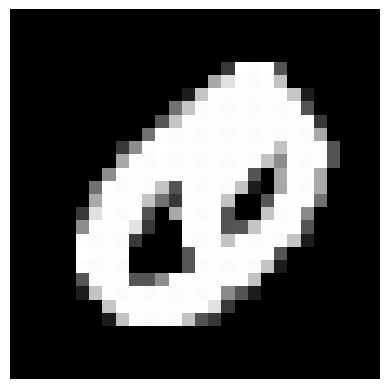

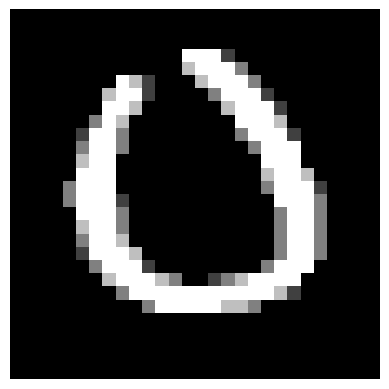

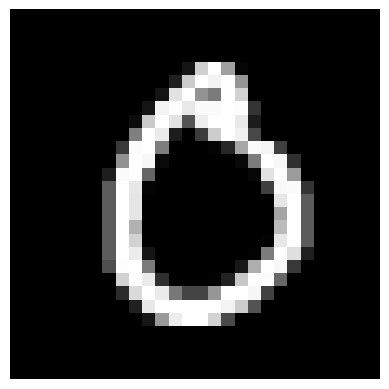

Incorrectly classified images for class 0


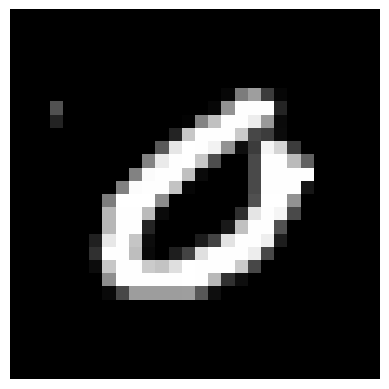

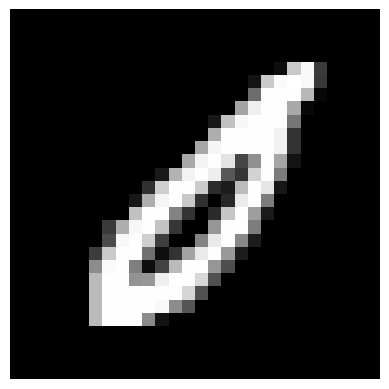

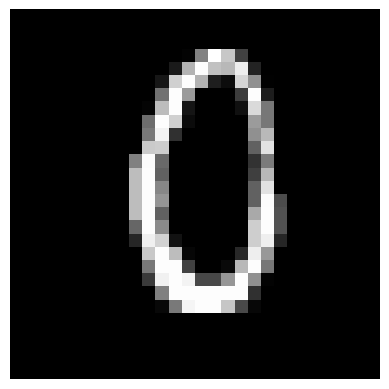

Correctly classified images for class 1


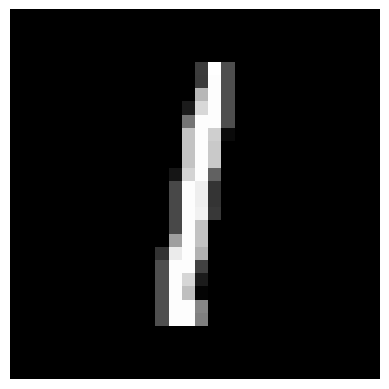

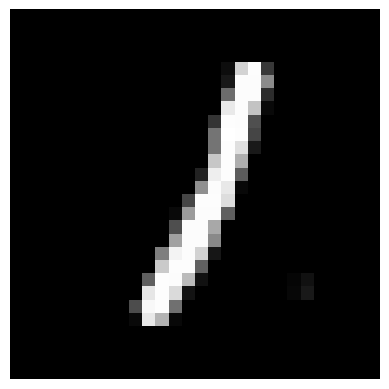

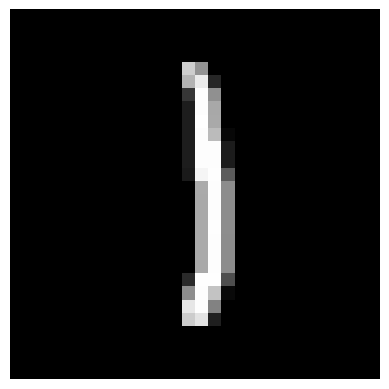

Incorrectly classified images for class 1


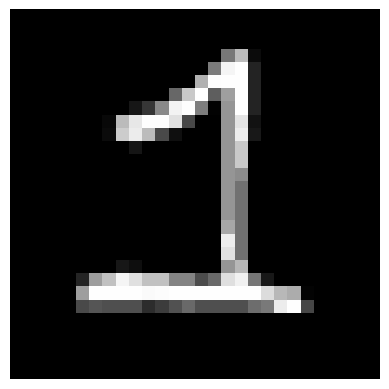

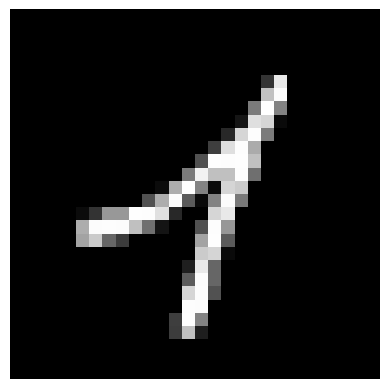

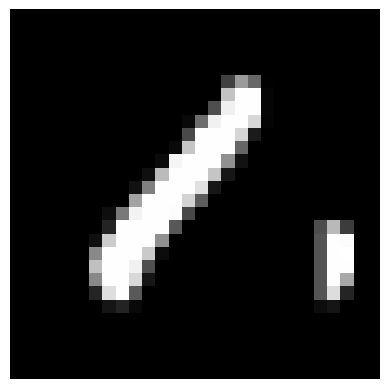

Correctly classified images for class 2


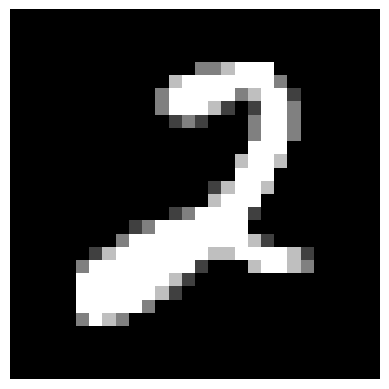

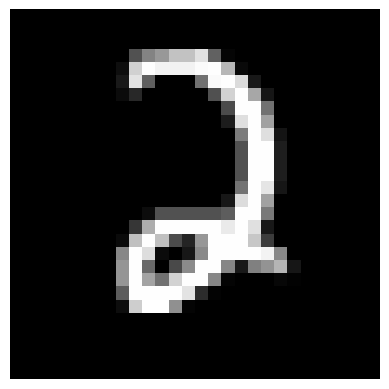

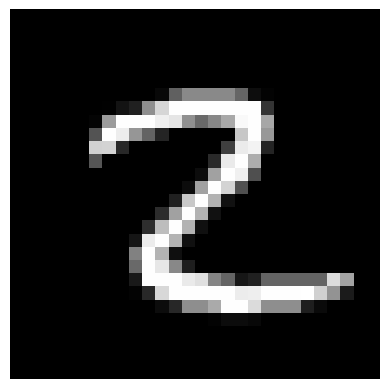

Incorrectly classified images for class 2


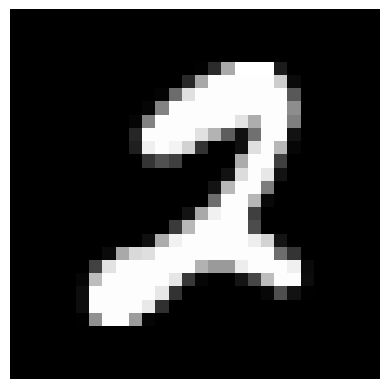

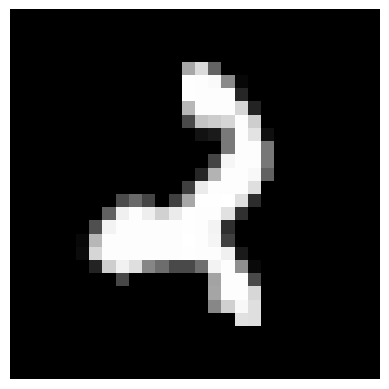

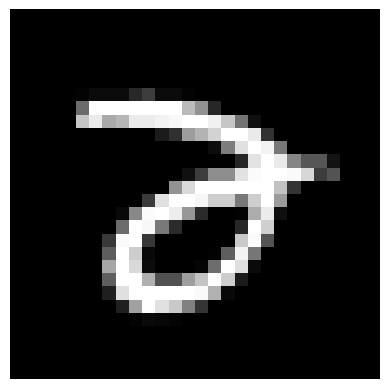

Correctly classified images for class 3


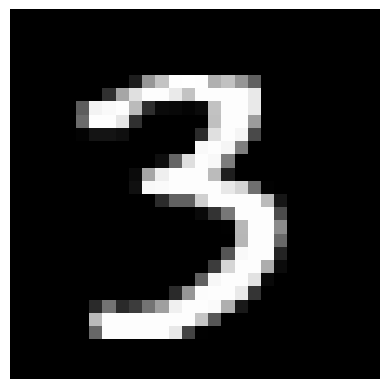

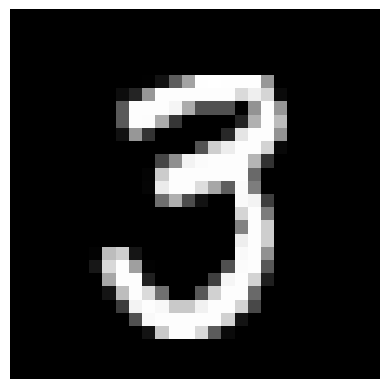

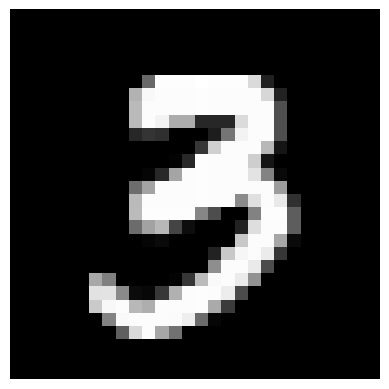

Incorrectly classified images for class 3


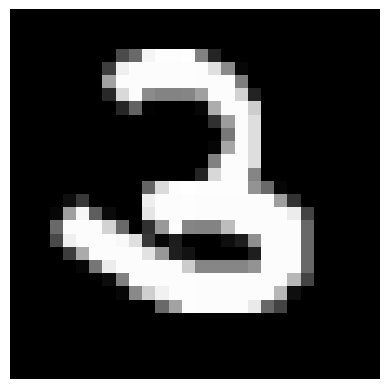

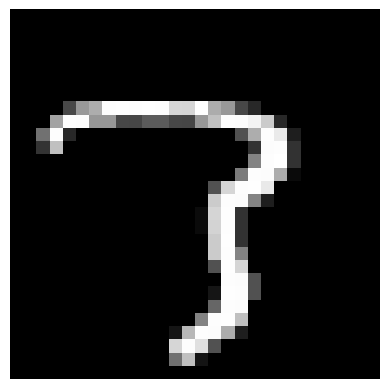

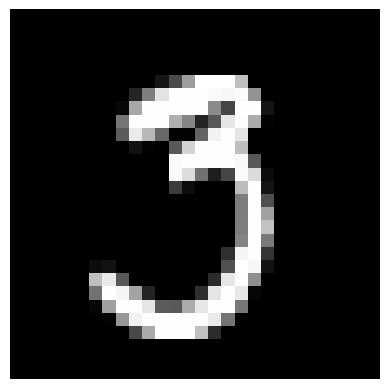

Correctly classified images for class 4


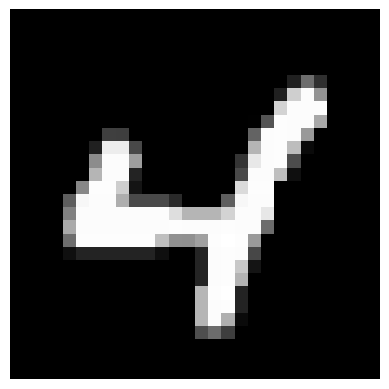

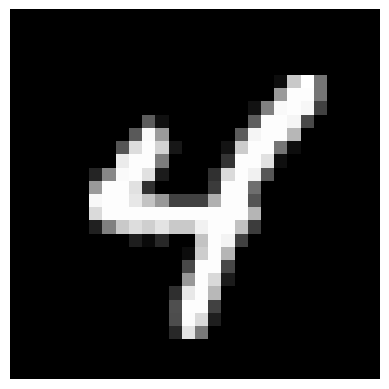

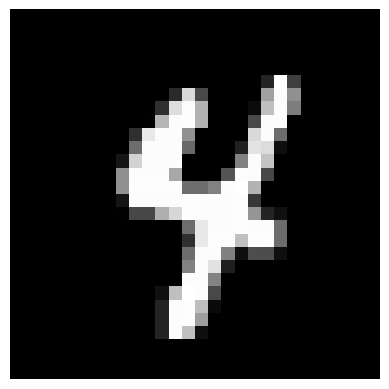

Incorrectly classified images for class 4


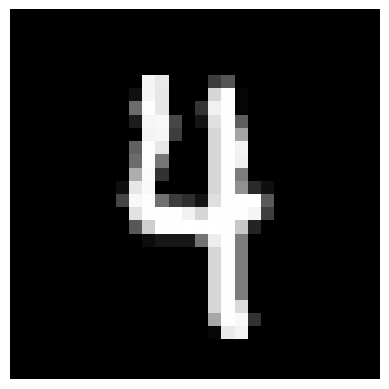

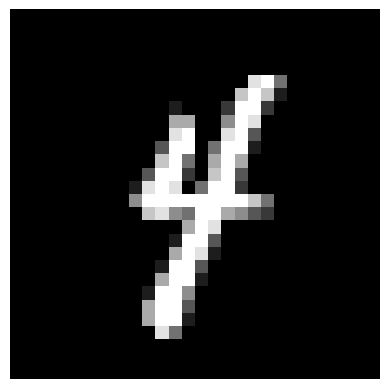

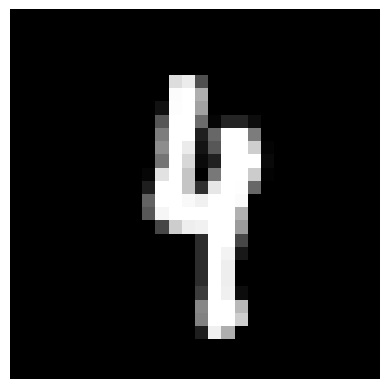

Correctly classified images for class 5


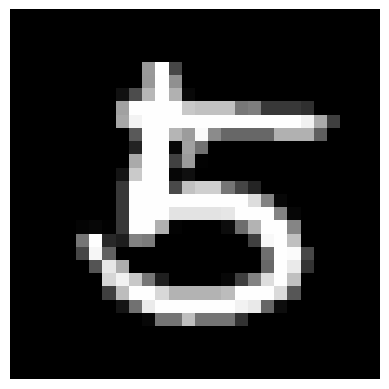

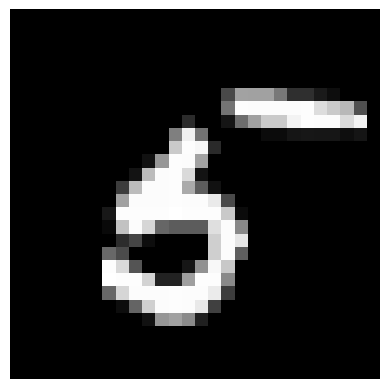

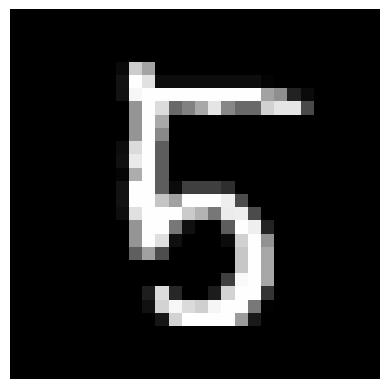

Incorrectly classified images for class 5


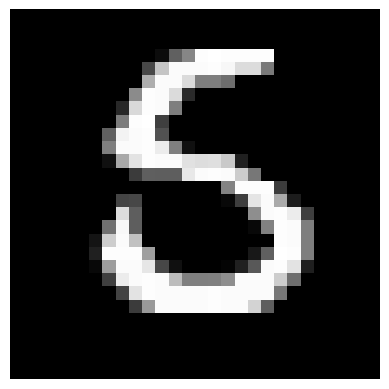

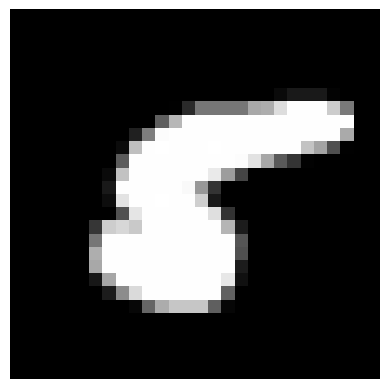

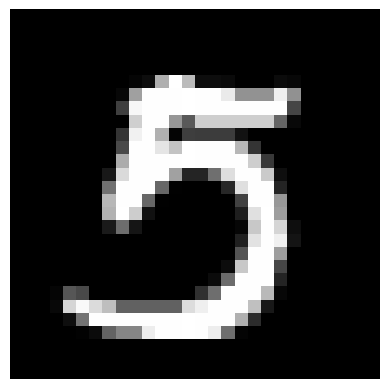

Correctly classified images for class 6


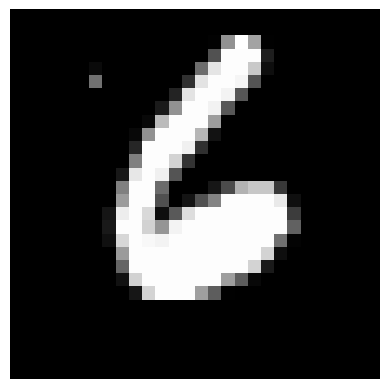

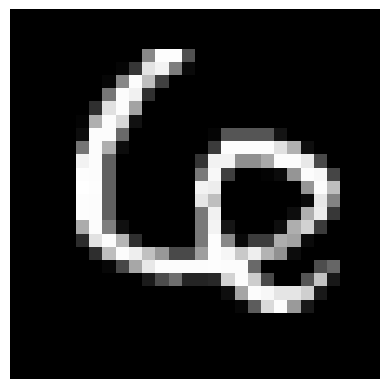

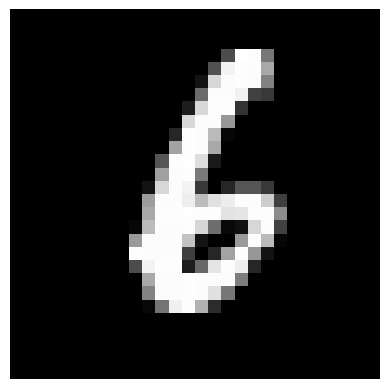

Incorrectly classified images for class 6


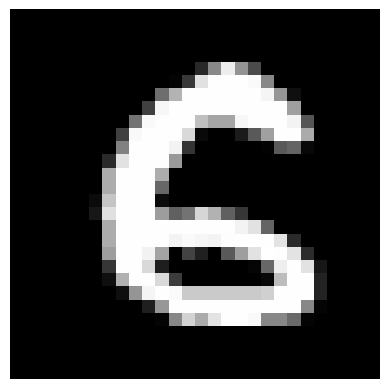

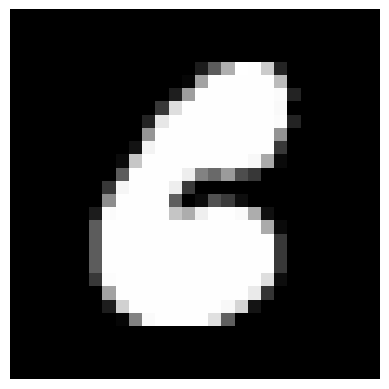

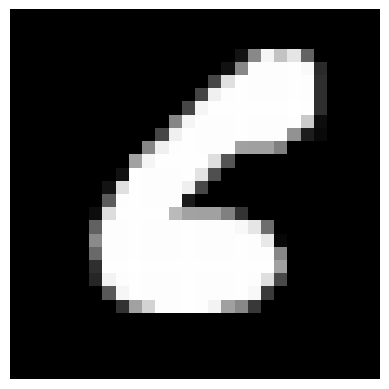

Correctly classified images for class 7


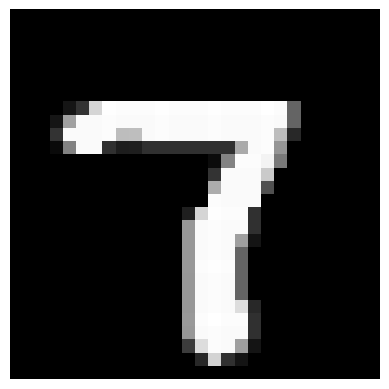

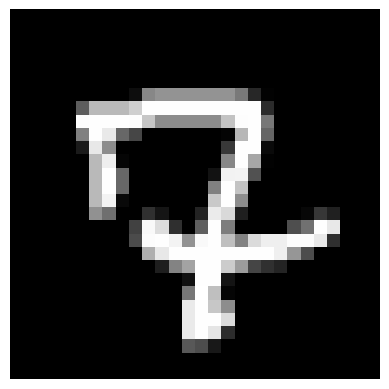

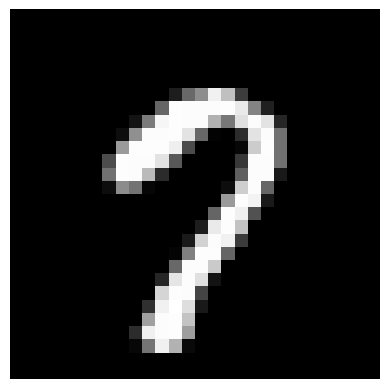

Incorrectly classified images for class 7


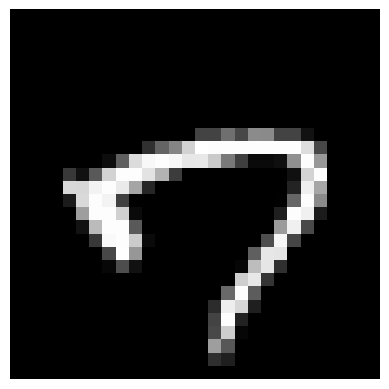

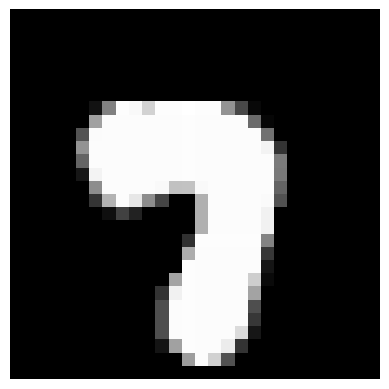

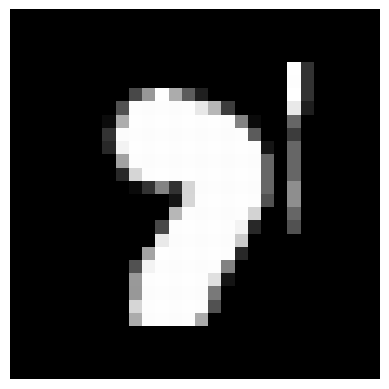

Correctly classified images for class 8


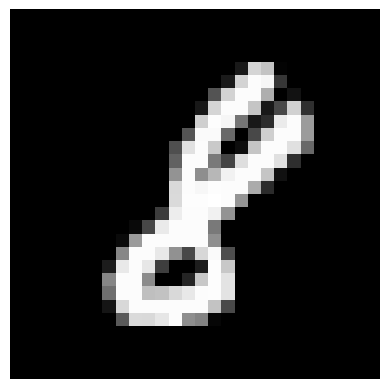

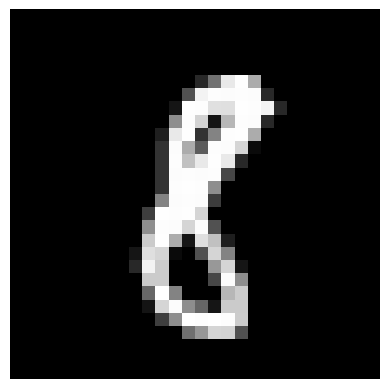

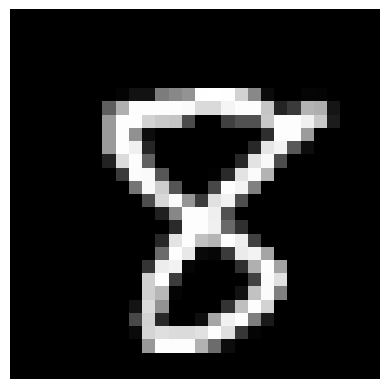

Incorrectly classified images for class 8


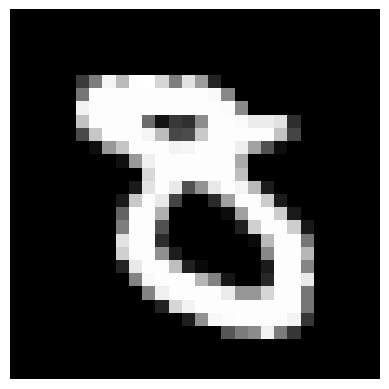

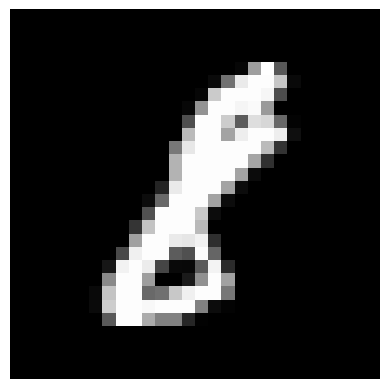

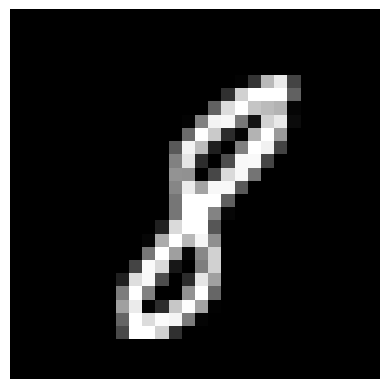

Correctly classified images for class 9


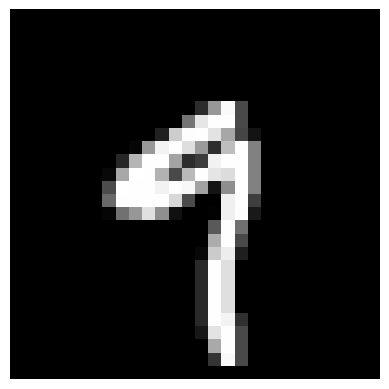

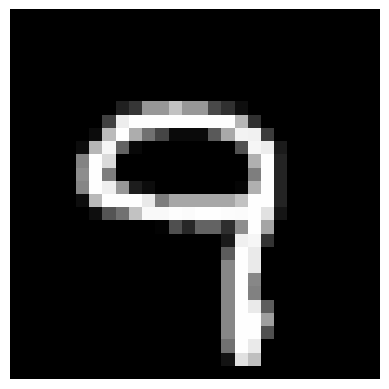

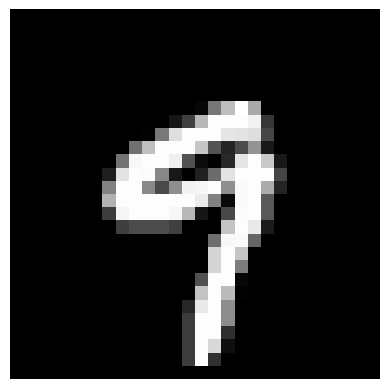

Incorrectly classified images for class 9


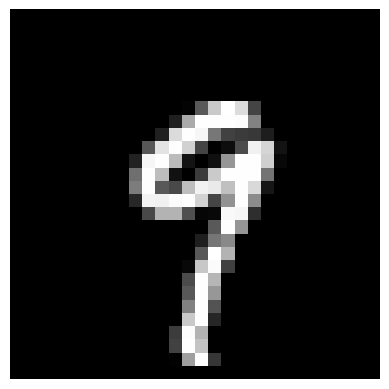

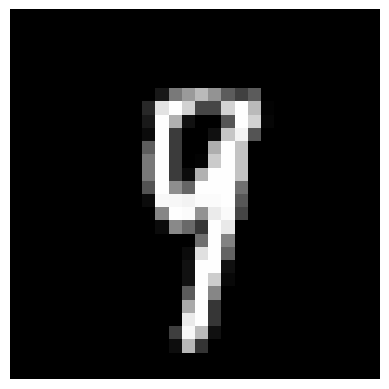

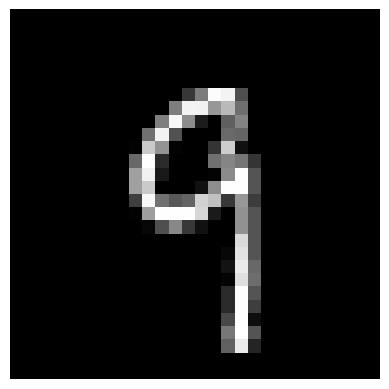

[('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0), ('0', 0),

In [ ]:
# Visualize correctly classified and incorrectly classified images for each class
num_samples = 3  # Number of samples to visualize for each class

for label in range(10):
    correctly_classified = []
    incorrectly_classified = []

    for i, true_label in enumerate(test_y):
        if int(true_label) == label:
            if true_label == predicted_labels[i]:
                correctly_classified.append(test_X[i])
            else:
                incorrectly_classified.append(test_X[i])           

    # Visualize correctly classified images
    print("Correctly classified images for class", label)
    for img in correctly_classified[:num_samples]:
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.show()

    # Visualize incorrectly classified images
    print("Incorrectly classified images for class", label)
    for img in incorrectly_classified[:num_samples]:
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.show()